In [34]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
import os

loader = PyPDFLoader(".pdf")
docs = loader.load()

In [35]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
chunks = text_splitter.split_documents(docs)

In [36]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))

In [37]:
from ragas.testset.graph import KnowledgeGraph
from ragas.testset.graph import Node, NodeType
kg = KnowledgeGraph()

for doc in docs:
    kg.nodes.append(
        Node(type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        ))
kg

KnowledgeGraph(nodes: 43, relationships: 0)

In [ ]:
from ragas.testset.transforms import apply_transforms
from ragas.testset.transforms import HeadlinesExtractor, HeadlineSplitter, KeyphrasesExtractor

headline_extractor = HeadlinesExtractor(llm=generator_llm, max_num=20)
headline_splitter = HeadlineSplitter(max_tokens=1500)
keyphrase_extractor = KeyphrasesExtractor(llm=generator_llm)

transforms = [
    headline_extractor,
    headline_splitter,
    keyphrase_extractor
]

apply_transforms(kg, transforms=transforms)

In [39]:
from ragas.testset.persona import Persona

persona_med_student = Persona(
    name="Medical Student",
    role_description="Is studying medicine and needs detailed, textbook-accurate explanations. Seeks clarity on complex topics, definitions, and step-by-step mechanisms."
)
persona_practicing_doctor = Persona(
    name="Practicing Doctor",
    role_description="Wants quick, clinically relevant answers. Prefers concise summaries, treatment protocols, and diagnostic guidelines with references to standard practice."
)
persona_patient_learner = Persona(
    name="Curious Patient",
    role_description="Is not from a medical background but is trying to understand their condition. Needs simplified explanations, definitions of medical terms, and empathetic communication."
)
persona_med_researcher = Persona(
    name="Medical Researcher",
    role_description="Engaged in research and interested in detailed insights, clinical trials, citations, and evidence-based discussions from medical literature."
)
persona_nurse = Persona(
    name="Nurse",
    role_description="Focuses on practical application of medical knowledge. Seeks nursing protocols, patient care procedures, and drug administration guidelines."
)
personas = [
    persona_med_student,
    persona_practicing_doctor,
    persona_patient_learner,
    persona_med_researcher,
    persona_nurse
]


In [40]:
from ragas.testset.synthesizers.single_hop.specific import (
    SingleHopSpecificQuerySynthesizer,
)

query_distibution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm, property_name="headlines"),0.5,),
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm, property_name="keyphrases"),0.5,),
]

In [41]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings,
    knowledge_graph=kg,
    persona_list=personas,
)

In [52]:
testset = generator.generate(testset_size=15, query_distribution=query_distibution)
#testset.to_pandas()

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/16 [00:00<?, ?it/s]

In [43]:
from langchain_openai.embeddings import OpenAIEmbeddings

from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI

embedding = OpenAIEmbeddings()
model = ChatOpenAI(model="gpt-4o-mini")

vectorstore = Chroma.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()


In [44]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [45]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [46]:
df = testset.to_pandas()

questions = []
grouth_truth = []

for index, row in df.iterrows():
    questions.append(row['user_input'])
    grouth_truth.append(row['reference'])

In [47]:
from datasets import Dataset

data = {"question": questions , "answer": [], "contexts": [], "ground_truth": grouth_truth}

for query in questions:
    data["answer"].append(rag_chain.invoke(query))
    data["contexts"].append(
        [doc.page_content for doc in retriever.invoke(query)]
    )

dataset = Dataset.from_dict(data)

In [48]:
first_entry = {
    "question": data["question"][0],
    "answer": data["answer"][0],
    "contexts": data["contexts"][0],
    "ground_truth": data["ground_truth"][0],
}
first_entry

{'question': 'What is Removal in medical context?',
 'answer': 'Based on the provided context, the specific details about "Removal" in the medical context are not explicitly stated. However, "Removal" generally refers to the process of eliminating or excising harmful or unnecessary tissues, pathogens, or substances from the body, often as part of the body\'s inflammatory response or healing process. For a more precise definition relevant to the document, additional details from the text would be necessary.',
 'contexts': ['RemovalRegulationRepair-----Recognition-- Recruitment-',
  'RemovalRegulationRepair-----Recognition-- Recruitment-',
  'organization- --\n-tion, the term repairhealing--',
  'organization- --\n-tion, the term repairhealing--'],
 'ground_truth': 'Removal is part of the process that involves Regulation, Repair, Recognition, and Recruitment.'}

In [49]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset=dataset,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    llm=model,
    embeddings=embedding
)

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

In [50]:
result.to_pandas()

,user_input,retrieved_contexts,response,reference,context_precision,context_recall,faithfulness,answer_relevancy
0,What is Removal in medical context?,[RemovalRegulationRepair-----Recognition-- Rec...,"Based on the provided context, the specific de...",Removal is part of the process that involves R...,0.0,1.000000,0.285714,0.000000
1,What does contraction of endothelial cells mean?,[-chemically mediated endothelial contraction ...,The context provided does not explicitly defin...,Contraction of endothelial cells refers to the...,0.0,1.000000,0.333333,0.000000
2,What is engulfment in simple words?,[Phagocytic Receptors. -NEngulfment. -leukocyt...,"Engulfment is the process by which a cell, suc...","Engulfment is when cells, like leukocytes, act...",1.0,1.000000,0.000000,0.909259
3,Can you elaborate on the clinical significance...,"[-----Abscesses, -----Abscesses, - BCADrubortu...",The context provided does not contain specific...,Abscesses are localized collections of pus tha...,0.0,0.000000,0.222222,0.000000
4,Can you explain the significance of the prolif...,[-- VasodilationMigration of endothelial cells...,The proliferation of endothelial cells is a cr...,The proliferation of endothelial cells is a cr...,1.0,0.666667,0.952381,0.946057
5,Can you provide a detailed explanation of diab...,[- --\nVenous leg ulcersArterial ulcersDiabet...,The provided context does not contain specific...,Diabetic ulcers are a type of wound that occur...,0.0,0.000000,1.000000,0.000000
6,Wht is the significnce of a cell in immunology?,[Cell[A conceptual discussion of world]Annu Re...,The significance of a cell in immunology lies ...,The context discusses various aspects of cells...,1.0,1.000000,0.777778,0.974250
7,What does J Leukoc Biol refer to in medical li...,[Sci Transl Med[An excellent the roles of diff...,"J Leukoc Biol refers to the ""Journal of Leukoc...",J Leukoc Biol refers to a journal that publish...,1.0,1.000000,1.000000,0.973681
8,Can you explain the significance of the suffix...,"[Although in ---itis-, Although in ---itis-, -...",The suffix '---itis-' in medical terminology i...,The suffix '---itis-' is used in medical termi...,0.0,0.000000,0.083333,0.958291
9,What does repair refer to in the context of nu...,"[organization- --\n-tion, the term repairheali...",The provided context does not contain specific...,"In the context provided, 'repair' is not expli...",0.0,1.000000,0.750000,0.000000


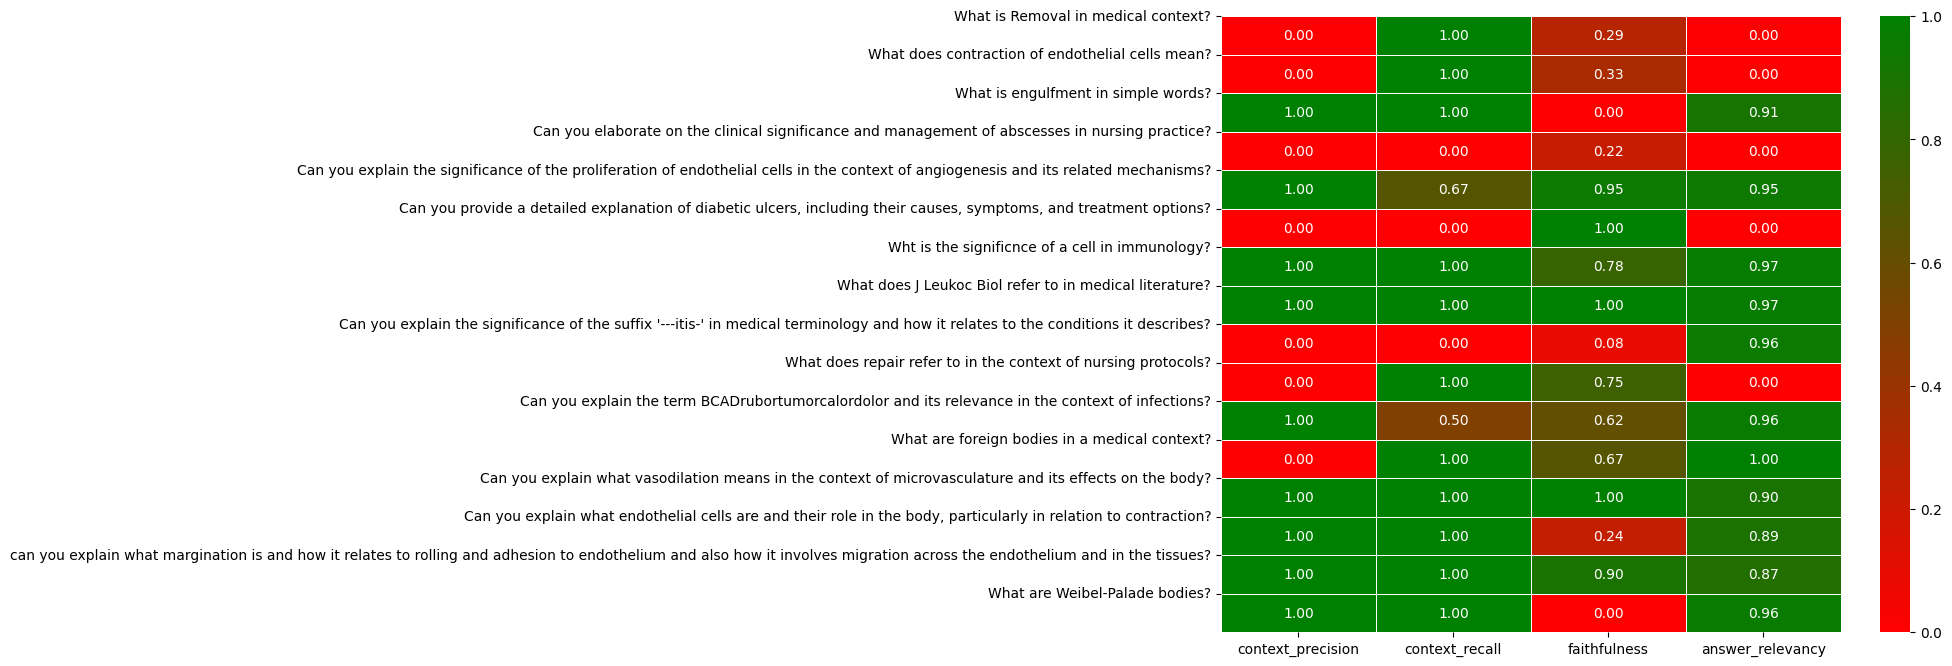

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[
    [
        "context_precision",
        "context_recall",
        "faithfulness",
        "answer_relevancy",
    ]
]

cmap = LinearSegmentedColormap.from_list("green_red", ["red", "green"])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=0.5, cmap=cmap)

plt.yticks(ticks=range(len(df["user_input"])), labels=df["user_input"], rotation=0)

plt.show()
